In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import keras
from keras.models import Sequential
from keras.layers import *
import keras.backend as K
from keras.models import load_model
from scipy.optimize import curve_fit,least_squares
from scipy.optimize import curve_fit
%cd gdrive/MyDrive/
path = r'path_datos_solar'

/content/gdrive/MyDrive


In [3]:
files =sorted(glob.glob(path + '*.csv'))
df = pd.concat((pd.read_csv(f, skiprows=2) for f in files), ignore_index=True)
df

Year  Month  Day  Hour  Minute  DHI  DNI  Dew Point  Surface Albedo  \
0      2015      1    1     0      30    0    0       24.0           0.117   
1      2015      1    1     1      30    0    0       24.0           0.117   
2      2015      1    1     2      30    0    0       24.0           0.117   
3      2015      1    1     3      30    0    0       23.0           0.117   
4      2015      1    1     4      30    0    0       23.0           0.117   
...     ...    ...  ...   ...     ...  ...  ...        ...             ...   
52555  2020     12   31    19      30    0    0       25.0           0.170   
52556  2020     12   31    20      30    0    0       24.9           0.170   
52557  2020     12   31    21      30    0    0       24.9           0.170   
52558  2020     12   31    22      30    0    0       25.0           0.170   
52559  2020     12   31    23      30    0    0       25.2           0.170   

       Wind Speed  Relative Humidity  Temperature  Pressure  
0             9.0              89.35         26.0      1010  
1             8.7              94.87         26.0      1010  
2             8.3              94.43         25.0      1010  
3             7.7              93.67         25.0      1010  
4             7.0              93.20         25.0      1010  
...           ...                ...          ...       ...  
52555         6.0              84.11         27.9      1012  
52556         6.1              84.88         27.7      1013  
52557         6.3              85.43         27.6      1013  
52558         6.5              86.43         27.5      1013  
52559         6.8              88.14         27.3      1013  

[52560 rows x 13 columns]

In [4]:
SAM = pd.read_csv('/SAM.csv', skiprows=32)
SAM

Month  Daily Average POA Irradiance (kWh/m2/day)  DC Array Output (kWh)  \
0       1                                      6.978              10633.190   
1       2                                      6.694               9183.890   
2       3                                      6.427               9614.831   
3       4                                      5.833               8437.555   
4       5                                      5.170               7691.173   
5       6                                      4.928               7076.468   
6       7                                      5.004               7416.769   
7       8                                      5.207               7693.112   
8       9                                      5.287               7607.501   
9      10                                      5.108               7633.269   
10     11                                      5.572               8163.763   
11     12                                      6.353               9577.541   

    AC System Output (kWh)  
0                10171.910  
1                 8780.493  
2                 9184.094  
3                 8050.968  
4                 7328.225  
5                 6738.342  
6                 7064.297  
7                 7330.466  
8                 7250.485  
9                 7274.314  
10                7794.093  
11                9148.689

In [5]:
df['date']=pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour', 'Minute']])
df

Year  Month  Day  Hour  Minute  DHI  DNI  Dew Point  Surface Albedo  \
0      2015      1    1     0      30    0    0       24.0           0.117   
1      2015      1    1     1      30    0    0       24.0           0.117   
2      2015      1    1     2      30    0    0       24.0           0.117   
3      2015      1    1     3      30    0    0       23.0           0.117   
4      2015      1    1     4      30    0    0       23.0           0.117   
...     ...    ...  ...   ...     ...  ...  ...        ...             ...   
52555  2020     12   31    19      30    0    0       25.0           0.170   
52556  2020     12   31    20      30    0    0       24.9           0.170   
52557  2020     12   31    21      30    0    0       24.9           0.170   
52558  2020     12   31    22      30    0    0       25.0           0.170   
52559  2020     12   31    23      30    0    0       25.2           0.170   

       Wind Speed  Relative Humidity  Temperature  Pressure  \
0             9.0              89.35         26.0      1010   
1             8.7              94.87         26.0      1010   
2             8.3              94.43         25.0      1010   
3             7.7              93.67         25.0      1010   
4             7.0              93.20         25.0      1010   
...           ...                ...          ...       ...   
52555         6.0              84.11         27.9      1012   
52556         6.1              84.88         27.7      1013   
52557         6.3              85.43         27.6      1013   
52558         6.5              86.43         27.5      1013   
52559         6.8              88.14         27.3      1013   

                     date  
0     2015-01-01 00:30:00  
1     2015-01-01 01:30:00  
2     2015-01-01 02:30:00  
3     2015-01-01 03:30:00  
4     2015-01-01 04:30:00  
...                   ...  
52555 2020-12-31 19:30:00  
52556 2020-12-31 20:30:00  
52557 2020-12-31 21:30:00  
52558 2020-12-31 22:30:00  
52559 2020-12-31 23:30:00  

[52560 rows x 14 columns]

In [6]:
maintenance = load_model('model_maintenance.keras')

In [7]:
maintenance.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 50)                7950      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 8001 (31.25 KB)
Trainable params: 8001 (31.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
import pickle

sc_i = MinMaxScaler()
sc_at = MinMaxScaler()
with open('minmax_scaler.pkl', 'rb') as file:
    sc_dt = pickle.load(file)

train_sc_I = sc_i.fit_transform(df[['DNI']])

train_sc_A = sc_at.fit_transform(df[['Dew Point']])


X_train_I = train_sc_I[:-1]

X_train_A = train_sc_A[:-1]

X_train_I = X_train_I[:, None]

X_train_A = X_train_A[:, None]

X_test_utb = concatenate([X_train_I, X_train_A  ], axis=1)

In [9]:
y_pred_final= maintenance.predict(X_test_utb)

1643/1643 [==============================] - 4s 2ms/step


In [11]:
datos = pd.DataFrame(sc_dt.inverse_transform(y_pred_final))
datos.columns=['PV']
datos['date'] = df['date']
datos['PV'][datos['PV']<0]=0
datos = datos.groupby([(datos.date.dt.year),(datos.date.dt.month)]).sum()
datos.index.names= ['year', 'month']
datos = datos.reset_index()
datos['date'] = pd.to_datetime(datos[['year', 'month']].assign(DAY=1))
datos = datos.drop(columns=['year', 'month'], axis =1)
datos

<ipython-input-11-2f82d7af1a47>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos['PV'][datos['PV']<0]=0
<ipython-input-11-2f82d7af1a47>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  datos = datos.groupby([(datos.date.dt.year),(datos.date.dt.month)]).sum()


PV       date
0   7821789.50 2015-01-01
1   7009697.50 2015-02-01
2   7250755.50 2015-03-01
3   5350367.00 2015-04-01
4   3940026.50 2015-05-01
..         ...        ...
67  2755862.50 2020-08-01
68  2954975.25 2020-09-01
69  3509591.75 2020-10-01
70  4042534.00 2020-11-01
71  7443901.00 2020-12-01

[72 rows x 2 columns]

In [12]:
SAM_ALL = SAM
for i in range(len(set(datos.date.dt.year))-1):
  SAM_ALL = SAM_ALL.append(SAM, ignore_index=True)
SAM_ALL

<ipython-input-12-ddef4925c525>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SAM_ALL = SAM_ALL.append(SAM, ignore_index=True)


Month  Daily Average POA Irradiance (kWh/m2/day)  DC Array Output (kWh)  \
0       1                                      6.978              10633.190   
1       2                                      6.694               9183.890   
2       3                                      6.427               9614.831   
3       4                                      5.833               8437.555   
4       5                                      5.170               7691.173   
..    ...                                        ...                    ...   
67      8                                      5.207               7693.112   
68      9                                      5.287               7607.501   
69     10                                      5.108               7633.269   
70     11                                      5.572               8163.763   
71     12                                      6.353               9577.541   

    AC System Output (kWh)  
0                10171.910  
1                 8780.493  
2                 9184.094  
3                 8050.968  
4                 7328.225  
..                     ...  
67                7330.466  
68                7250.485  
69                7274.314  
70                7794.093  
71                9148.689  

[72 rows x 4 columns]

Text(0.5, 1.0, 'Prediction Production System with maintenance')

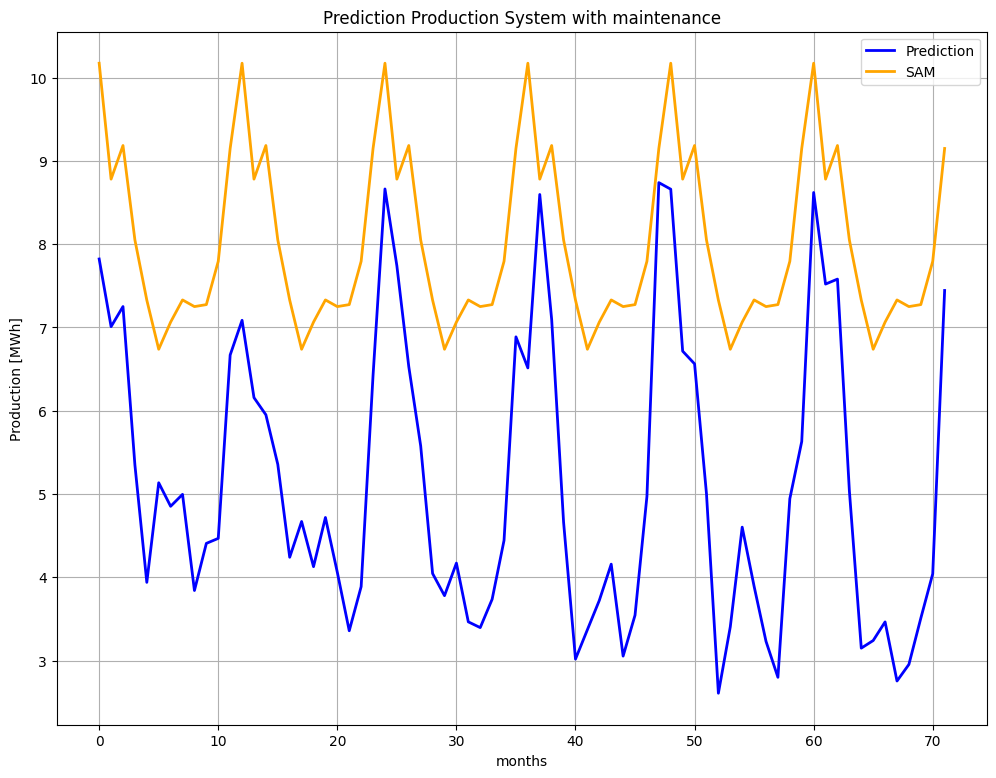

In [13]:
plt.figure(figsize=(12,9))
plt.plot(datos['PV']/(1000*1000),'b', linewidth=2.0, label='Prediction')
plt.plot(SAM_ALL['AC System Output (kWh)']/1000,'orange', linewidth=2.0, label='SAM')
plt.xlabel('months')
plt.ylabel('Production [MWh]')
plt.grid()
plt.legend()
plt.title('Prediction Production System with maintenance')

Text(0.5, 1.0, 'Performance Indicator System with maintenance')

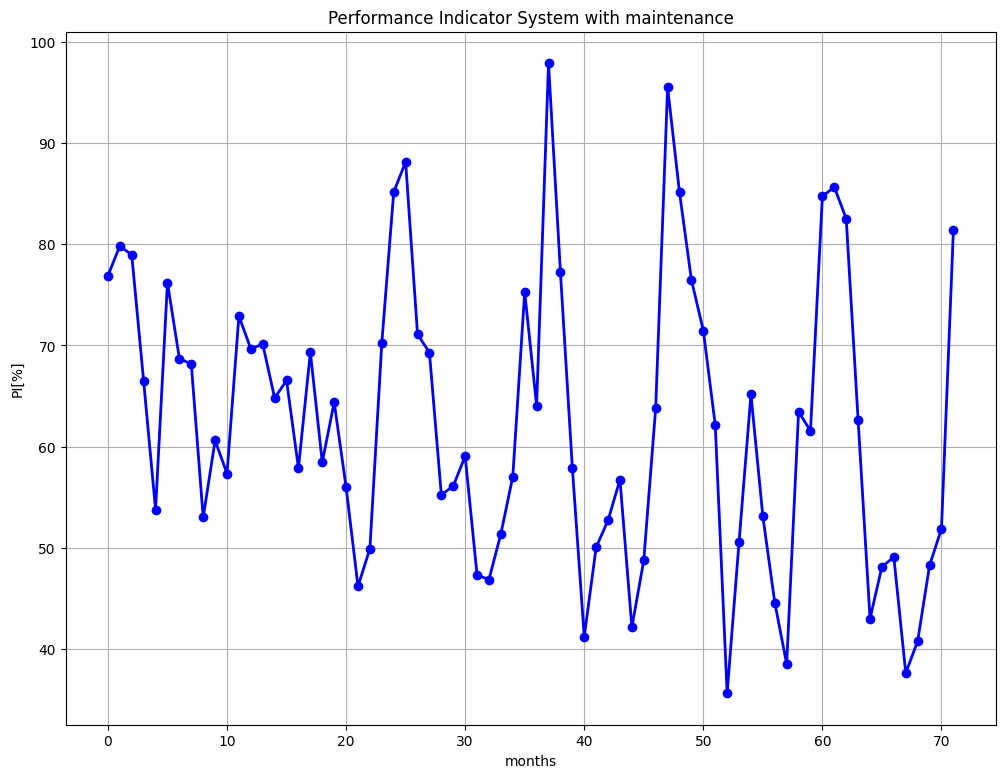

In [14]:
PI = 100*datos['PV']/(1000*SAM_ALL['AC System Output (kWh)'])
#PR_Mal = 100*datos_Mala['PV']/(1000*SAM_ALL['AC System Output (kWh)'])
plt.figure(figsize=(12,9))
plt.plot(PI, '-bo', linewidth=2.0)
#plt.plot(PR_Mal, '-ro', linewidth=2.0)
plt.xlabel('months')
plt.ylabel('PI[%]')
plt.grid()
plt.title('Performance Indicator System with maintenance')

<ipython-input-15-de0f4ce547b6>:3: RuntimeWarning: overflow encountered in exp
  return a*np.exp(-b*x)
<ipython-input-15-de0f4ce547b6>:3: RuntimeWarning: overflow encountered in multiply
  return a*np.exp(-b*x)


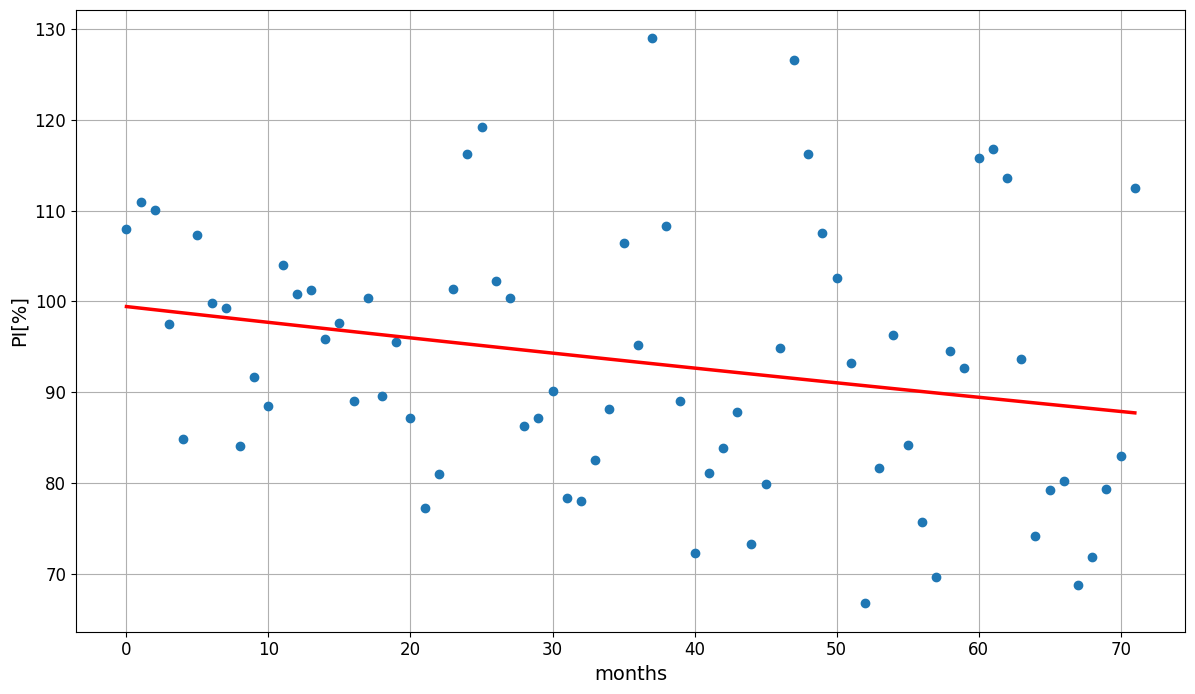

In [15]:
import math
def modelo(x,a,b):
    return a*np.exp(-b*x)

x  = np.array(PI.index)
y = np.array(PI)+108-PI[0]

myline = np.linspace(0, max(x), 100)

popt, pcov = curve_fit(modelo, x, y, maxfev=2000)

x_modelo  = np.linspace(0, max(x),  max(x))


plt.figure(figsize=(12, 7))
plt.plot( x,                 y,  'o', label='data')
plt.plot(x_modelo, modelo(x_modelo, *popt), 'r-', label='model', linewidth=2.5)
#plt.legend(loc='best')
plt.xlabel('months', fontsize="14")
plt.ylabel('PI[%]', fontsize="14")
plt.tight_layout()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()

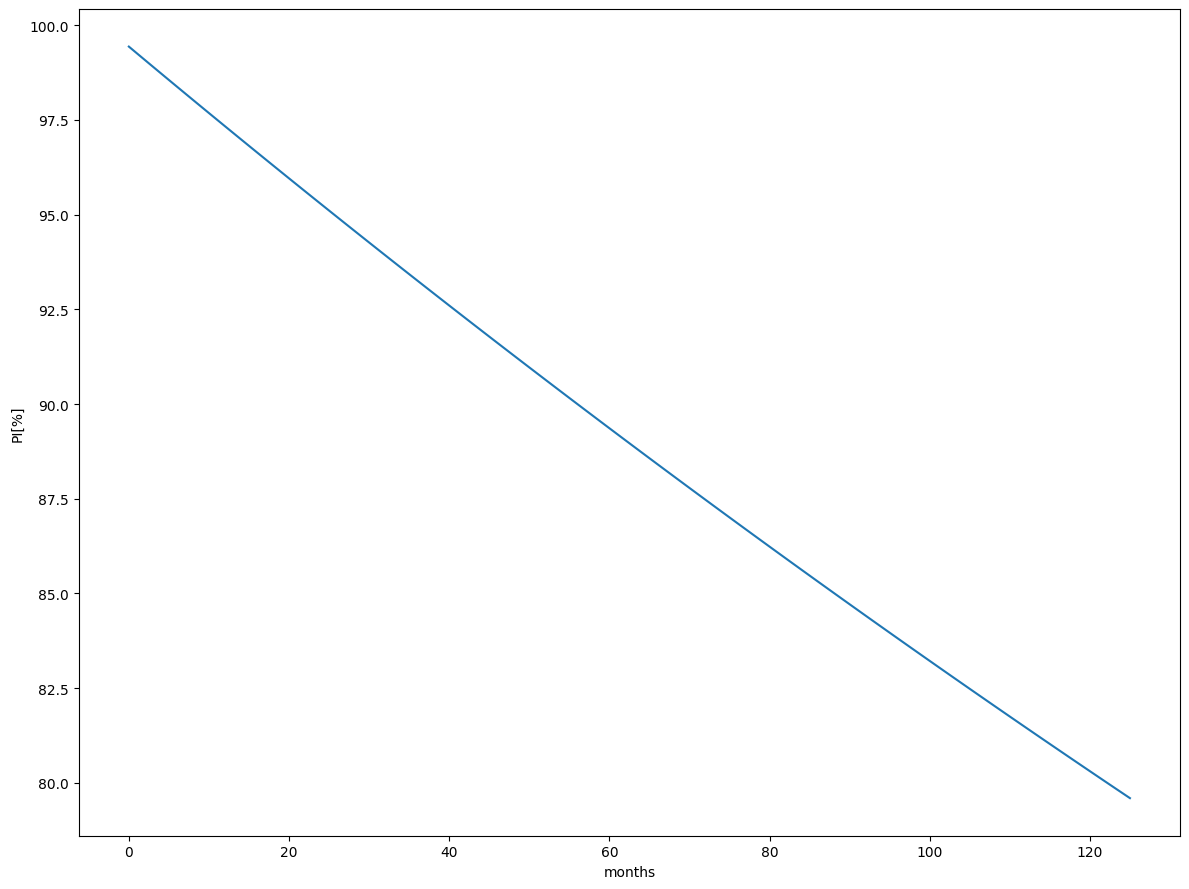

In [16]:
x = np.linspace(0, 126, 126)
y = popt[0]*np.exp(-popt[1]*x)
plt.figure(figsize=(12,9))
plt.plot(y)
plt.xlabel('months')
plt.ylabel('PI[%]')
plt.tight_layout()

In [17]:
date_range = pd.date_range(start='2015/1/1', end='2050/12/1', freq='MS').tolist()

#Generate Points
x = np.linspace(0, len(date_range), len(date_range))
y = popt[0]*np.exp(-popt[1]*x)

y2 =100*np.exp(-(0.0074845805847479843*x))

pr_model = pd.DataFrame(y)

pr_model.columns = ['PI']
pr_model['date'] = date_range

pr_model['PI No mantain'] = pd.DataFrame(y2)
pr_model = pr_model.set_index('date')

pi_anual = round(pr_model.groupby(pr_model.index.year).mean(),2)

pi_anual.index.names = ['year']



In [18]:
m = pi_anual['PI'][2015]
y = []
x = []
y.append(m)
x.append(m)
for i in range(len(pi_anual)-1):
  y.append(round(y[i]*.98,2))
  x.append(round(x[i]*(1-0.005),2))
print(y)

[98.47, 96.5, 94.57, 92.68, 90.83, 89.01, 87.23, 85.49, 83.78, 82.1, 80.46, 78.85, 77.27, 75.72, 74.21, 72.73, 71.28, 69.85, 68.45, 67.08, 65.74, 64.43, 63.14, 61.88, 60.64, 59.43, 58.24, 57.08, 55.94, 54.82, 53.72, 52.65, 51.6, 50.57, 49.56, 48.57]


In [19]:
pi_anual['PI Middle'] = y
pi_anual['PI Low'] = x
pi_anual['PI Zero'] = pi_anual['PI'][2015]
pi_anual['PI No mantain'] += pi_anual['PI'][2015]- pi_anual['PI No mantain'][2015]
pi_anual = pi_anual.reset_index()
pi_anual['year'] = pi_anual['year'].astype(int)
pi_anual = pi_anual.set_index('year')
pi_anual

PI  PI No mantain  PI Middle  PI Low  PI Zero
year                                                  
2015  98.47          98.47      98.47   98.47    98.47
2016  96.40          90.21      96.50   97.98    98.47
2017  94.38          82.65      94.57   97.49    98.47
2018  92.39          75.75      92.68   97.00    98.47
2019  90.45          69.44      90.83   96.52    98.47
2020  88.55          63.68      89.01   96.04    98.47
2021  86.69          58.41      87.23   95.56    98.47
2022  84.87          53.60      85.49   95.08    98.47
2023  83.08          49.19      83.78   94.60    98.47
2024  81.34          45.17      82.10   94.13    98.47
2025  79.63          41.50      80.46   93.66    98.47
2026  77.96          38.14      78.85   93.19    98.47
2027  76.32          35.07      77.27   92.72    98.47
2028  74.71          32.26      75.72   92.26    98.47
2029  73.14          29.70      74.21   91.80    98.47
2030  71.61          27.36      72.73   91.34    98.47
2031  70.10          25.21      71.28   90.88    98.47
2032  68.63          23.26      69.85   90.43    98.47
2033  67.19          21.47      68.45   89.98    98.47
2034  65.77          19.83      67.08   89.53    98.47
2035  64.39          18.34      65.74   89.08    98.47
2036  63.04          16.97      64.43   88.63    98.47
2037  61.71          15.73      63.14   88.19    98.47
2038  60.42          14.59      61.88   87.75    98.47
2039  59.15          13.54      60.64   87.31    98.47
2040  57.90          12.59      59.43   86.87    98.47
2041  56.69          11.72      58.24   86.44    98.47
2042  55.50          10.93      57.08   86.01    98.47
2043  54.33          10.20      55.94   85.58    98.47
2044  53.19           9.53      54.82   85.15    98.47
2045  52.07           8.93      53.72   84.72    98.47
2046  50.98           8.37      52.65   84.30    98.47
2047  49.90           7.86      51.60   83.88    98.47
2048  48.86           7.40      50.57   83.46    98.47
2049  47.83           6.98      49.56   83.04    98.47
2050  46.82           6.59      48.57   82.62    98.47

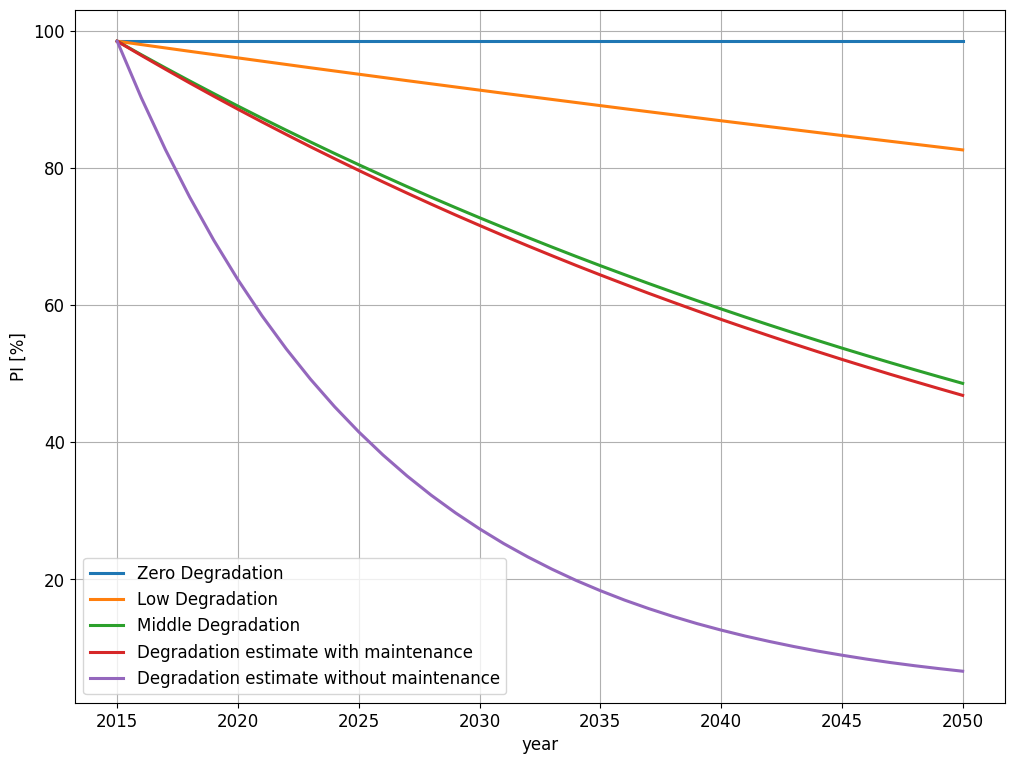

In [20]:
plt.figure(figsize=(12,9))
plt.plot(pi_anual['PI Zero'], linewidth=2.2, label='Zero Degradation')
plt.plot(pi_anual['PI Low'], linewidth=2.2, label='Low Degradation')
plt.plot(pi_anual['PI Middle'], linewidth=2.2, label='Middle Degradation')
plt.plot(pi_anual['PI'], linewidth=2.2, label='Degradation estimate with maintenance')
plt.plot(pi_anual['PI No mantain'], linewidth=2.2, label='Degradation estimate without maintenance')
plt.legend(fontsize="12")
plt.ylabel('PI [%]', fontsize ="12")
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('year', fontsize="12")
plt.grid(   )
plt.show()

In [21]:
m = 0.20
y = []
y.append(m)
for i in range(len(pi_anual)-1):
  y.append((y[i]*1.075))
print(y)
pi_anual['precio_kwh'] =  y

year = SAM.sum()

design_system = 60.8*8*365
design_system2=round(year['AC System Output (kWh)'])


[0.2, 0.215, 0.231125, 0.24845937499999998, 0.267093828125, 0.287125865234375, 0.30866030512695314, 0.33180982801147463, 0.3566955651123352, 0.3834477324957603, 0.4122063124329423, 0.44312178586541295, 0.4763559198053189, 0.5120826137907177, 0.5504888098250216, 0.5917754705618982, 0.6361586308540405, 0.6838705281680935, 0.7351608177807004, 0.7902978791142529, 0.8495702200478218, 0.9132879865514084, 0.981784585542764, 1.0554184294584712, 1.1345748116678565, 1.2196679225429456, 1.3111430167336666, 1.4094787429886915, 1.5151896487128433, 1.6288288723663065, 1.7509910377937794, 1.8823153656283127, 2.023489018050436, 2.1752506944042187, 2.338394496484535, 2.513774083720875]


In [22]:
pi_anual[['kW 2% degradation', 'kW 0.5% degradation', 'kW 0% degradation']] =  round(pi_anual[['PI Middle', 	'PI Low', 	'PI Zero']]*design_system/100).astype(int)

pi_anual[['kW our degradation', 'kW our degradation no mantainance']] =  round(pi_anual[['PI', 'PI No mantain']]*design_system2/100).astype(int)

pi_anual['income our degradation'] = pi_anual['precio_kwh']*(pi_anual['kW our degradation'])

pi_anual['income our degradation no mantainance'] = pi_anual['precio_kwh']*(pi_anual['kW our degradation no mantainance'])

pi_anual['income 2% degradation'] = pi_anual['precio_kwh']*(pi_anual['kW 2% degradation'])

pi_anual['income 0.5% degradation'] = pi_anual['precio_kwh']*(pi_anual['kW 0.5% degradation'])

pi_anual['income 0% degradation'] = pi_anual['precio_kwh']*(pi_anual['kW 0% degradation'])

pi_anual

PI  PI No mantain  PI Middle  PI Low  PI Zero  precio_kwh  \
year                                                                 
2015  98.47          98.47      98.47   98.47    98.47    0.200000   
2016  96.40          90.21      96.50   97.98    98.47    0.215000   
2017  94.38          82.65      94.57   97.49    98.47    0.231125   
2018  92.39          75.75      92.68   97.00    98.47    0.248459   
2019  90.45          69.44      90.83   96.52    98.47    0.267094   
2020  88.55          63.68      89.01   96.04    98.47    0.287126   
2021  86.69          58.41      87.23   95.56    98.47    0.308660   
2022  84.87          53.60      85.49   95.08    98.47    0.331810   
2023  83.08          49.19      83.78   94.60    98.47    0.356696   
2024  81.34          45.17      82.10   94.13    98.47    0.383448   
2025  79.63          41.50      80.46   93.66    98.47    0.412206   
2026  77.96          38.14      78.85   93.19    98.47    0.443122   
2027  76.32          35.07      77.27   92.72    98.47    0.476356   
2028  74.71          32.26      75.72   92.26    98.47    0.512083   
2029  73.14          29.70      74.21   91.80    98.47    0.550489   
2030  71.61          27.36      72.73   91.34    98.47    0.591775   
2031  70.10          25.21      71.28   90.88    98.47    0.636159   
2032  68.63          23.26      69.85   90.43    98.47    0.683871   
2033  67.19          21.47      68.45   89.98    98.47    0.735161   
2034  65.77          19.83      67.08   89.53    98.47    0.790298   
2035  64.39          18.34      65.74   89.08    98.47    0.849570   
2036  63.04          16.97      64.43   88.63    98.47    0.913288   
2037  61.71          15.73      63.14   88.19    98.47    0.981785   
2038  60.42          14.59      61.88   87.75    98.47    1.055418   
2039  59.15          13.54      60.64   87.31    98.47    1.134575   
2040  57.90          12.59      59.43   86.87    98.47    1.219668   
2041  56.69          11.72      58.24   86.44    98.47    1.311143   
2042  55.50          10.93      57.08   86.01    98.47    1.409479   
2043  54.33          10.20      55.94   85.58    98.47    1.515190   
2044  53.19           9.53      54.82   85.15    98.47    1.628829   
2045  52.07           8.93      53.72   84.72    98.47    1.750991   
2046  50.98           8.37      52.65   84.30    98.47    1.882315   
2047  49.90           7.86      51.60   83.88    98.47    2.023489   
2048  48.86           7.40      50.57   83.46    98.47    2.175251   
2049  47.83           6.98      49.56   83.04    98.47    2.338394   
2050  46.82           6.59      48.57   82.62    98.47    2.513774   

      kW 2% degradation  kW 0.5% degradation  kW 0% degradation  \
year                                                              
2015             174820               174820             174820   
2016             171322               173950             174820   
2017             167896               173080             174820   
2018             164540               172210             174820   
2019             161256               171358             174820   
2020             158025               170506             174820   
2021             154865               169653             174820   
2022             151776               168801             174820   
2023             148740               167949             174820   
2024             145757               167115             174820   
2025             142845               166280             174820   
2026             139987               165446             174820   
2027             137182               164611             174820   
2028             134430               163795             174820   
2029             131749               162978             174820   
2030             129122               162161             174820   
2031             126548               161345             174820   
2032             124009               160546             174820   
2033    

In [23]:
costo_inicial = -120_000
costo_traditional = costo_inicial
costo_i = costo_inicial
costo_t = costo_inicial
costo_f = costo_inicial
pi_anual['maintenance'] = 0.02*-costo_inicial

x = []
y = []
z = []
w = []
p = []


x.append(costo_inicial)
p.append(costo_f)
y.append(costo_traditional)
z.append(costo_t)
w.append(costo_i)

for i in pi_anual.index:
  costo_inicial += pi_anual['income our degradation'][i]
  costo_inicial -= pi_anual['maintenance'][i]
  costo_f += pi_anual['income our degradation no mantainance'][i]
  costo_traditional += pi_anual['income 2% degradation'][i]
  costo_t += pi_anual['income 0.5% degradation'][i]
  costo_i += pi_anual['income 0% degradation'][i]

  x.append(costo_inicial)
  p.append(costo_f)
  y.append(costo_traditional)
  z.append(costo_t)
  w.append(costo_i)
pi_anual['outcome our degradation'] = x[:-1]
pi_anual['outcome our degradation no mantainance'] = p[:-1]
pi_anual['outcome 2% degradation'] = y[:-1]
pi_anual['outcome 0.5% degradation'] = z[:-1]
pi_anual['outcome 0% degradation'] = w[:-1]

pi_anual

PI  PI No mantain  PI Middle  PI Low  PI Zero  precio_kwh  \
year                                                                 
2015  98.47          98.47      98.47   98.47    98.47    0.200000   
2016  96.40          90.21      96.50   97.98    98.47    0.215000   
2017  94.38          82.65      94.57   97.49    98.47    0.231125   
2018  92.39          75.75      92.68   97.00    98.47    0.248459   
2019  90.45          69.44      90.83   96.52    98.47    0.267094   
2020  88.55          63.68      89.01   96.04    98.47    0.287126   
2021  86.69          58.41      87.23   95.56    98.47    0.308660   
2022  84.87          53.60      85.49   95.08    98.47    0.331810   
2023  83.08          49.19      83.78   94.60    98.47    0.356696   
2024  81.34          45.17      82.10   94.13    98.47    0.383448   
2025  79.63          41.50      80.46   93.66    98.47    0.412206   
2026  77.96          38.14      78.85   93.19    98.47    0.443122   
2027  76.32          35.07      77.27   92.72    98.47    0.476356   
2028  74.71          32.26      75.72   92.26    98.47    0.512083   
2029  73.14          29.70      74.21   91.80    98.47    0.550489   
2030  71.61          27.36      72.73   91.34    98.47    0.591775   
2031  70.10          25.21      71.28   90.88    98.47    0.636159   
2032  68.63          23.26      69.85   90.43    98.47    0.683871   
2033  67.19          21.47      68.45   89.98    98.47    0.735161   
2034  65.77          19.83      67.08   89.53    98.47    0.790298   
2035  64.39          18.34      65.74   89.08    98.47    0.849570   
2036  63.04          16.97      64.43   88.63    98.47    0.913288   
2037  61.71          15.73      63.14   88.19    98.47    0.981785   
2038  60.42          14.59      61.88   87.75    98.47    1.055418   
2039  59.15          13.54      60.64   87.31    98.47    1.134575   
2040  57.90          12.59      59.43   86.87    98.47    1.219668   
2041  56.69          11.72      58.24   86.44    98.47    1.311143   
2042  55.50          10.93      57.08   86.01    98.47    1.409479   
2043  54.33          10.20      55.94   85.58    98.47    1.515190   
2044  53.19           9.53      54.82   85.15    98.47    1.628829   
2045  52.07           8.93      53.72   84.72    98.47    1.750991   
2046  50.98           8.37      52.65   84.30    98.47    1.882315   
2047  49.90           7.86      51.60   83.88    98.47    2.023489   
2048  48.86           7.40      50.57   83.46    98.47    2.175251   
2049  47.83           6.98      49.56   83.04    98.47    2.338394   
2050  46.82           6.59      48.57   82.62    98.47    2.513774   

      kW 2% degradation  kW 0.5% degradation  kW 0% degradation  \
year                                                              
2015             174820               174820             174820   
2016             171322               173950             174820   
2017             167896               173080             174820   
2018             164540               172210             174820   
2019             161256               171358             174820   
2020             158025               170506             174820   
2021             154865               169653             174820   
2022             151776               168801             174820   
2023             148740               167949             174820   
2024             145757               167115             174820   
2025             142845               166280             174820   
2026             139987               165446             174820   
2027             137182               164611             174820   
2028             134430               163795             174820   
2029             131749               162978             174820   
2030             129122               162161             174820   
2031             126548               161345             174820   
2032             124009               160546             174820   
2033    

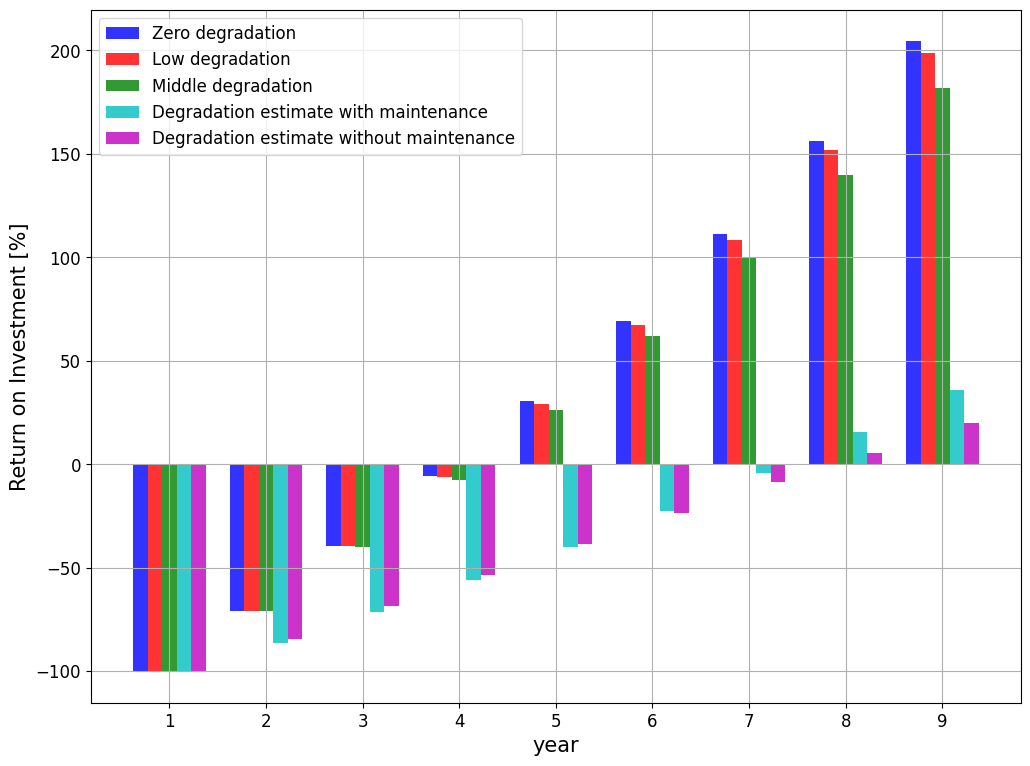

In [24]:
pi_anual.index = np.arange(1, len(pi_anual) + 1)
money = 100*pi_anual[['outcome 0% degradation', 'outcome 0.5% degradation', 'outcome 2% degradation', 'outcome our degradation', 'outcome our degradation no mantainance']][:9]/120_000

m = (100--73.864571)/(8-1)

y = m*np.arange(0,9)-73.864571
datos = pd.DataFrame(y)
datos.index +=1
datos.columns = ['roi']

m0 = money['outcome 0% degradation']
m1 = money['outcome 0.5% degradation']
m2 = money['outcome 2% degradation']
m3 = money['outcome our degradation']
m4 = money['outcome our degradation no mantainance']

fig, ax = plt.subplots(figsize=(12,9))

bar_width = 0.35
opacity = 0.8
index = np.arange(1,1+len(m0))


bar_width = 0.15
opacity = 0.8
index = np.arange(1, 1+len(m0))

rects1 = ax.bar(index + bar_width, m0, bar_width, alpha=opacity, color='b', label='Zero degradation')
rects2 = ax.bar(index + 2*bar_width, m1, bar_width, alpha=opacity, color='r', label='Low degradation')
rects3 = ax.bar(index + 3*bar_width, m2, bar_width, alpha=opacity, color='g', label='Middle degradation')
rects4 = ax.bar(index + 4*bar_width, m3, bar_width, alpha=opacity, color='c', label='Degradation estimate with maintenance')
rects5 = ax.bar(index + 5*bar_width, m4, bar_width, alpha=opacity, color='m', label='Degradation estimate without maintenance')

plt.ylabel('Return on Investment [%]', fontsize="15")
plt.xlabel('year', fontsize="15")
plt.legend(loc='upper left', fontsize="12")

ax.set_xticks(index + 3*bar_width)
ax.set_xticklabels(m0.index)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

plt.grid()
plt.show()